# Cooking ingredients recommendation 

## Non-negative matrix factorization
This notebook builds a recommendation system for cooking ingredients using non-negative matrix factorization.  


In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [1]:
# Python standard libraries
import ast 
import csv
import os
import pickle
import random
import re
import statistics
import time
from collections import Counter 
from itertools import combinations


# Third party imports 
import gensim
import h5py
import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gensim.models import Word2Vec
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from matplotlib import style
plt.style.use('ggplot')
from sklearn.decomposition import NMF, PCA

# custom functions
import functions as fn

In [2]:
 from gensim.models.coherencemodel import CoherenceModel

# 0. Load data    

In [3]:
# load encoded training and CV data
with open("data/ingredient_recommendation/train_encoded.csv", "rb") as f:
    train_encoded = pickle.load(f)
with open("data/ingredient_recommendation/CV_encoded.csv", "rb") as f:
    CV_encoded = pickle.load(f)
with open("data/ingredient_recommendation/test_encoded.csv", "rb") as f:
    test_encoded = pickle.load(f)


In [4]:
# load tokenizer from preprocessing step
with open('models/tokenizer.pickle', 'rb') as handle:
    t = pickle.load(handle)

# create dictionary from index to words 
index_to_words=dict(map(reversed,t.word_index.items())) 

# number of words
n_words = len(t.word_index)
print('number of words: ', n_words)

number of words:  6712


# 2. Non-negative matrix factorization


<b> Summary </b> 
* Since we are building a recommender, I first tried collaborative filtering via non-negative matrix factorization. 
* The latent variables (roughly) correspond to type of cuisine, such as baking, Italian food, Mexican food, ... .  
* Non-negative matrix factorization requires the user to specify the number of latent variables (topics). I implemented two different ways of identifying the appropriate number of latent variables:
    * I first selected the number of latent variables by evaluating the recommenders on a cross-validation set. The optimal number of latent variables was 6. 
    * However, this seemed like a very low number, since our dataset clearly contains more than 6 different types of cuisine. 
    * The "optimal" number of latent variables may be very low because of the bias in our dataset. 
    * I then considered NMF as a language model, and used the coherence score to select the number of latent variables.  
    * The coherence score is maximized when we use 20 latent variables.

<b> The idea behind non-negative matrix factorization (NMF) & recommender </b>  
* Let V be a documents-ingredients matrix.
    * Each row of V corresponds to a document.
    * Each column of V corresponds to an ingredient.  
    * V [ i ][ j ] = 1 if document "i" contains ingredient "j", and 0 otherwise. 
    
* Given a matrix V, NMF factorizes V into non-negative matrices W and H such that $ W H \approx V$. 
![](files/images/NMF_annotated.png)  

* Each row of V is approximated by a linear combination of the rows of H. The coefficients of this linear combination is given by the rows of W.  
* W is a (document) x (latent topic) matrix  
* H is a (latent topic) x (ingredients) matrix   
* The factorization $ W H \approx V$ learns latent features underlying the interactions between recipes and ingredients.  
* Given a list of ingredients (a row vector $r$ in V), use the approximated row vector $\tilde r$ to recommend ingredients that have high entries in $\tilde r$. 

## &nbsp; 2.1 Prepare data and features

In [24]:
# prepare (documents) x (ingredients) matrix V for NMF factorization

# create matrix V from the training set
V = np.zeros((len(train_encoded), n_words))
for i, doc in enumerate(train_encoded):
    for j in doc:
        V[i,j] = 1


In [29]:
# split CV set into existing and missing ingredients
existing, missing, sampled_idx = fn.sample_ingredients(CV_encoded, 5)

In [24]:
with open("data/NMF/V.csv", "wb") as f:
    pickle.dump(V,f)

In [23]:
# save data for NMF cross validation in multi-processing
with open("data/NMF/CV_existing.csv", "wb") as f:
    pickle.dump(existing,f)
with open("data/NMF/CV_missing.csv", "wb") as f:
    pickle.dump(missing,f)
with open("data/NMF/CV_sampled_idx.csv", "wb") as f:
    pickle.dump(sampled_idx,f)

## &nbsp; 2.2 Perform NMF and build an example recommender

* Note: We will use an arbitrary number of latent variables, say 20.  
* Say we found non-negative matrices W and H such that $ W H \approx V$  
* There are two different types of recommenders one can build: a deterministic and probabilistic recommender:  
    * <b> deterministic recommender </b> 
        * Given a list of ingredients, find the approximation of the document, as computed by $ W H $. Recommend ingredients with the highest coefficients in the resulting approximation.  
        * Recommended ingredients may be too similar across documents.  
        * Faster than the probabilistic recommender.  
    * <b> probabilistic recommender </b> 
        * Use the coefficients of W and H to define probability distributions. 
        * Given a list of ingredients, sample to topic. Once the topic has been selected, sample the ingredients.  
        * Introduces more variety to the recommender.  
        * Slower than the deterministic recommender. 
* Because of computational speed, we'll use the <b>deterministic recommender</b>
        

In [7]:
# Find NMF with 20 latent variables
model_20 = NMF(n_components = 20)
model_20.fit(V)

C:\Users\irish\anaconda3\envs\recipes\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


NMF(n_components=20)

In [27]:
def recommender_NMF(model, existing, n_words, n):
    # Deterministic recommender based on a factorized NMF model.
    # Given a list of existing ingredients, compute V_approx from NMF
    # For each document, recommend ingredients that 
    #    (1) are not present in the existing ingredients list
    #    (2) are not cuisine types
    #    (3) have high coefficients in the V_approx 
    
    """
    --- input ---
    model: trained NMF model (sklearn)
    existing_ing: (list of lists) Each item is a list of integers corresponding to the 
                ingredients present in the document
    n_words: (int) total number of ingredients 
    n: (int) number of ingredients to recommend
    
    --- output ---
    recommend: (list of lists) Each item is a list of "n" ingredients recommended
    """   
    
    # create matrix V from existing ingredients
    V = np.zeros((len(existing), n_words))
    for i, doc in enumerate(existing):
        for j in doc:
            V[i,j] = 1
            
    # find approximation to V using NNM
    H = model.components_
    W = model.transform(V)
    V_approx = np.matmul(W, H)
    
    # remove existing ingredients from V_approx (set entry to 0)
    for i, doc in enumerate(existing):
        for item in doc:
            V_approx[i, item] = 0

    # find ingredients with high coefficients in V_approx 
    V_idx = np.argsort(V_approx, axis = 1)
    recommend = V_idx[:,-n:].tolist()

    # turn above into list of ingredients (recommended)
    #recommend = [[idx_to_word[idx+1] for idx in rec] for rec in V_recommend] 
    
    return recommend

In [9]:
# get recommendations
recommend = recommender_NMF(model_20, existing, n_words, 6)

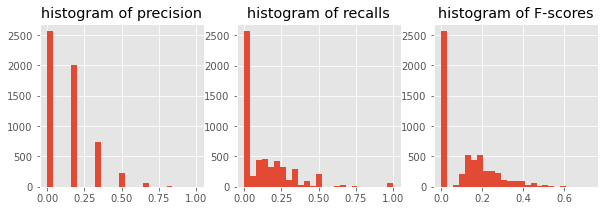

Median precision on cross validation set:  0.16666666666666666
Median recall on cross validation set:  0.08333333333333333
Median F-score on cross validation set:  0.1111111111111111
Mean precision on cross validation set:  0.13260688341074192
Mean recall on cross validation set:  0.13127902532631947
Mean F-score on cross validation set:  0.11970723506166196


In [12]:
scores = [fn.compute_scores(recommend[i], missing[i]) for i in range(len(missing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions, bins = 25)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls, bins = 25)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores, bins = 25)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Median precision on cross validation set: ", statistics.median(precisions) )
print("Median recall on cross validation set: ", statistics.median(recalls) )
print("Median F-score on cross validation set: ", statistics.median(Fscores) )

print("Mean precision on cross validation set: ", statistics.mean(precisions) )
print("Mean recall on cross validation set: ", statistics.mean(recalls) )
print("Mean F-score on cross validation set: ", statistics.mean(Fscores) )

In [14]:
# Show example recommendations 
for i in random.sample(range(len(existing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print([index_to_words[item+1] for item in existing[i]])
    print("---------- Recommended ingredients ----------")
    print([index_to_words[item+1] for item in recommend[i]])
    print("---------- Missing ingredients ----------")
    print([index_to_words[item+1] for item in missing[i]], '\n')



==================== Example 1179 ====================
---------- Existing ingredients ----------
['jicama', 'lime', 'cucumber', 'cayenne', 'mexican']
---------- Recommended ingredients ----------
['chopped_cilantro_fresh', 'avocado', 'sour_cream', 'chili_powder', 'jalapeno_chilies', 'ground_cumin']
---------- Missing ingredients ----------
['paprika'] 

==================== Example 5346 ====================
---------- Existing ingredients ----------
['italian', 'onions', 'basil', 'tomato_sauce', 'olive_oil']
---------- Recommended ingredients ----------
['dry_white_wine', 'fresh_basil', 'fresh_parsley', 'tomatoes', 'grated_parmesan_cheese', 'extra-virgin_olive_oil']
---------- Missing ingredients ----------
['garlic', 'roma_tomatoes', 'mexican_oregano', 'dry_red_wine', 'tomato_purã©e'] 

==================== Example 4146 ====================
---------- Existing ingredients ----------
['garlic', 'parsley', 'italian', 'pinenuts', 'olive_oil']
---------- Recommended ingredients ---------

## &nbsp; 2.3 Select number of latent variables

* To use NMF models, one needs to specify the number of latent variables  
* I used two different approaches to determine the appropriate number of latent variables

i. cross-validation evaluation of recommender built on various number of latent variables  
ii. coherence scores  

* According to the cross-validation evaluation, the number of appropriate number of topics is 5. However, I thought that this number is too low, as our dataset clearly consists of more than 5 different types of cuisine.  
* I then decided to choose the number of latent variables to be the number that leads to the highest coherence score. The optimal number of topics is 20. 


### 2(c) i. Using recommender performance on cross-validation set

* The following code finds NMF for various dimensions. 
* I used multiprocessing to speed up the process 

In [ ]:
# Evaluate NMF models of various topic numbers
topic_numbers = list(range(1, 30))
cv_mean_scores = {}
cv_median_scores = {}

for k in topic_numbers:
    
    # Find NMF decompositions
    model = NMF(n_components = k)
    model.fit(V)

    # make recommendations on cross validation set
    recommend_ing = recommender_NMF(model, existing, n_words, cuisine, 6)
    
    # compute scores
    scores = [fn.compute_scores(recommend_ing[i], missing[i]) for i in range(len(missing))]

    precisions = [item[0] for item in scores] 
    recalls = [item[1] for item in scores]
    Fscores = [item[2] for item in scores]
    
    cv_mean_scores[k] = [statistics.mean(precisions), statistics.mean(recalls), statistics.mean(Fscores)]
    cv_median_scores[k] = [statistics.median(precisions), statistics.median(recalls), statistics.median(Fscores)]
    
# save
#f = open("models/NMF/latentdim_CV.pkl","wb")
#pickle.dump(cv_mean_scores,f)
#f.close()

#f = open("models/NMF/latentdim_CV.pkl","wb")
#pickle.dump(cv_median_scores,f)
#f.close()


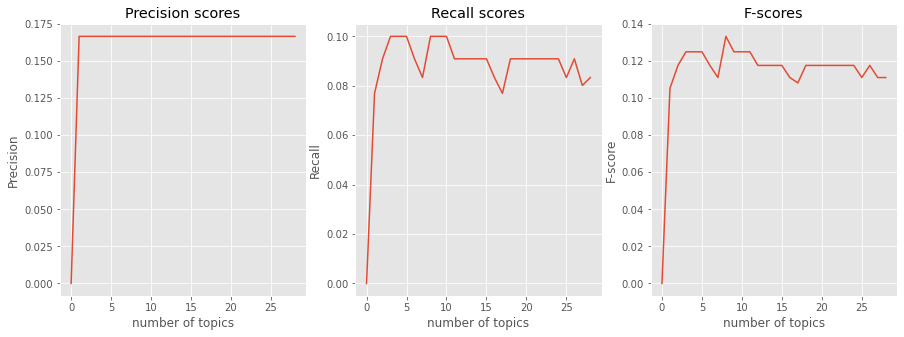

In [12]:
# open CV scores
cv_scores = pickle.load( open( "models/NMF/latentdim_CV.csv", "rb" ) )
topic_numbers = range(29)
#cv_scores = cv_mean_scores

fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].plot(topic_numbers, [cv_scores[item][1] for item in topic_numbers])
ax[0].set_xlabel('number of topics')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision scores')

ax[1].plot(topic_numbers, [cv_scores[item][2] for item in topic_numbers])
ax[1].set_xlabel('number of topics')
ax[1].set_ylabel('Recall')
ax[1].set_title('Recall scores')

ax[2].plot(topic_numbers, [cv_scores[item][3] for item in topic_numbers])
ax[2].set_xlabel('number of topics')
ax[2].set_ylabel('F-score')
ax[2].set_title('F-scores')
plt.show()

F-score is maximized when number of topics is around 9.  


<b> The need for a different number of latent variables </b>  
* While the cross-validation evaluation method found the optimal number of topics to be 9, I thought that this number was too low.  
* Our dataset clearly has more than 9 topics. Performing NMF with 9 latent oversimplifies the different types of cuisine we have.  
* For example, the last cell shows the recommended ingredients for three different types of cuisine involving chicken. Note that basically identical ingredients are recommended for both Korean and Thai style cooking.  


### 2(c) ii. Using coherence scores
* We'll select the number of latent variables to be the number of topics that maximizes coherence scores
* For computing the coherence score, we'll use NMF via gensim

In [5]:
# load balanced training set 
df_train = pd.read_csv('data/ingredient_recommendation/balanced_training.csv')
df_train.drop("Unnamed: 0", axis = 1, inplace = True)

# get training documents
train_doc = [ast.literal_eval(df_train.document[idx]) for idx in range(df_train.shape[0])]

In [6]:
# create dictionary (from words in both training and CV set)
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))
# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

common_dict = Dictionary(documents)

In [7]:
train_corpus = [common_dict.doc2bow(text) for text in train_doc] 

In [12]:
# prepare CV wet text for computing coherence scores

f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
cv_idx = list(f.get("cv_idx"))
f.close()

CV_doc = [documents[i] for i in cv_idx]
CV_corpus = [common_dict.doc2bow(text) for text in CV_doc]

In [113]:
# Prepare data for gensim

# Create dictionary
#common_dictionary = Dictionary(documents)

# Prepare BOW features for training set
#train_text = [documents[idx] for idx in train_idx]
#train_corpus = [common_dictionary.doc2bow(text) for text in train_text]  

# Prepare CV set text for computing coherence scores
#cv_text = [documents[idx] for idx in cv_idx]

In [ ]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(1,100,4))
scores = {}

for k in topic_numbers:
    # train NMF model 
    nmf = Nmf(train_corpus, id2word = common_dict, num_topics = k)
   
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=CV_doc, window_size = 60, coherence='c_uci')
    coherence = cm.get_coherence() 
    scores[k] = coherence
    
# save
f = open("models/NMF/NMF_coherence2.pkl","wb")
pickle.dump(scores,f)
f.close()

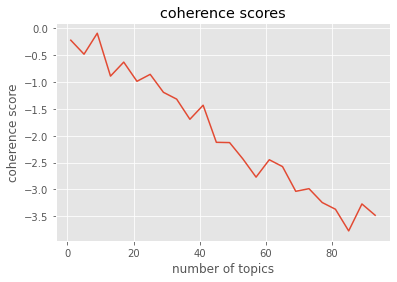

In [29]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

Based on the above graph, the number of topics that leads to the highest coherence score is around 17.  
For fun, let's take a look at the topics learned by the 17 topics

In [44]:
# train NMF model 
gensim_nmf = Nmf(train_corpus, id2word = common_dict, num_topics = 17)

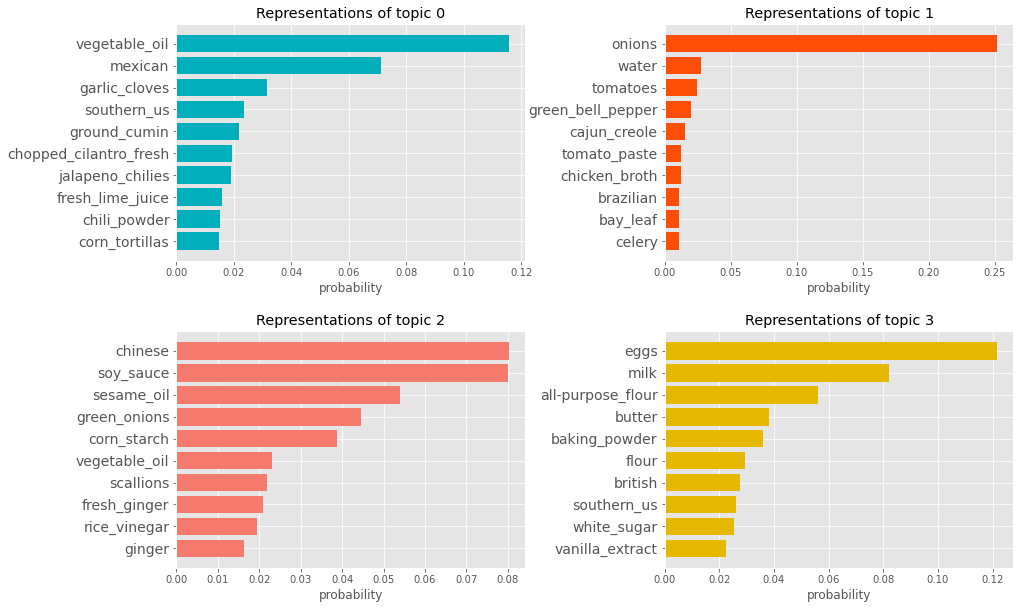

In [45]:
# Visualize topic representations for 4 (out of 17) topics
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
colors = ["#00AFBB", "#FC4E07", "#f57a6c", "#E7B800"]

for i in range(4):
    row = i // 2
    col = i % 2
    
    topic_rep = gensim_nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob, color = colors[i])
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

The above graph shows the top 10 most probable ingredients for 4 of the 17 topics learned by NMF. 
* Topic 0 seems to represent ingredients for Mexican and Southern US food  
* Topic 1 is a bit hard to tell... It looks like onion gets its own topic? 
* Topic 2 seems to represent ingredients for Chinese cuisine  
* Topic 3 seems to represent ingredients for baking

## &nbsp; 2.4 Build a recommender

In [25]:
# Find NMF with 17 latent variables
model_17 = NMF(n_components = 17)
model_17.fit(V)

NMF(n_components=17)

In [ ]:
# save model
with open("models/NMF/NMF_17.pkl", 'wb') as file:
    pickle.dump(model_17, file)

In [30]:
# get recommendations
recommend = recommender_NMF(model_17, existing, n_words, 6)

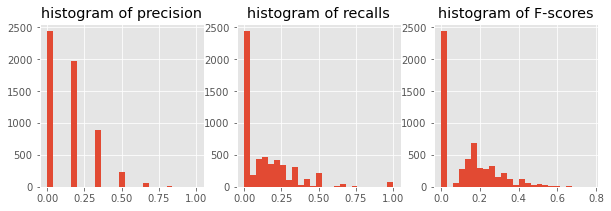

Median precision on cross validation set:  0.16666666666666666
Median recall on cross validation set:  0.1
Median F-score on cross validation set:  0.125
Mean precision on cross validation set:  0.14115160176253425
Mean recall on cross validation set:  0.14111682604000128
Mean F-score on cross validation set:  0.12839659632844982


In [32]:
scores = [fn.compute_scores(recommend[i], missing[i]) for i in range(len(missing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions, bins = 25)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls, bins = 25)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores, bins = 25)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Median precision on cross validation set: ", statistics.median(precisions) )
print("Median recall on cross validation set: ", statistics.median(recalls) )
print("Median F-score on cross validation set: ", statistics.median(Fscores) )

print("Mean precision on cross validation set: ", statistics.mean(precisions) )
print("Mean recall on cross validation set: ", statistics.mean(recalls) )
print("Mean F-score on cross validation set: ", statistics.mean(Fscores) )

In [33]:
# Show example recommendations 
for i in random.sample(range(len(existing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print([index_to_words[item+1] for item in existing[i]])
    print("---------- Recommended ingredients ----------")
    print([index_to_words[item+1] for item in recommend[i]])
    print("---------- Missing ingredients ----------")
    print([index_to_words[item+1] for item in missing[i]], '\n')



==================== Example 5243 ====================
---------- Existing ingredients ----------
['ground_cumin', 'indian', 'coriander_seeds', 'onions', 'black_mustard_seeds']
---------- Recommended ingredients ----------
['ginger', 'oil', 'cumin_seed', 'ground_turmeric', 'tomatoes', 'garam_masala']
---------- Missing ingredients ----------
['tumeric', 'cilantro_sprigs', 'large_garlic_cloves', 'red_chili_peppers', 'vegetable_oil', 'gingerroot', 'coconut_milk', 'lump_crab_meat', 'scallion_greens', 'coarse_salt', 'black_peppercorns'] 

==================== Example 5027 ====================
---------- Existing ingredients ----------
['water', 'green_onions', 'korean', 'sugar', 'soybean_paste']
---------- Recommended ingredients ----------
['japanese', 'scallions', 'corn_starch', 'sesame_oil', 'chinese', 'soy_sauce']
---------- Missing ingredients ----------
['vegetable_oil', 'flour'] 

==================== Example 5184 ====================
---------- Existing ingredients ----------
['lar

The model doesn't seem to perform very well as a recommendation system. See the following section for ideas for improvement.

## &nbsp; 2.5 Ideas for improvement

1. Selecting the number of latent variables
    * Evaluation on cross-validation resulted in 6 latent variables. The coherence score resulted in 20 latent variables.
    * Note that 20 is still a low number of latent variables. For example, one of the topics (topic 1) represented a mix of various east asian cuisine excluding Chinese cuisine. A recommender based on this model could recommend a mix of ingredients that do not necessarily go well together. 
    * Cross-validation for unsupervised learning models can be difficult. There are some other ways to perform cross-validation on NMF, as illustrated in this <a href="http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/">blog post</a>.    
2. Tackling bias in dataset.  
    * We can gather more data to create a more diverse dataset.  
3. Sampling based recommender.  
    * In order to add variety to the ingredients recommended, we can build a recommender that sample ingredients according to a probability distribution determined by NMF model. We will need more computing power for this to be feasible. 
    * Try cloud computing.  
4. Differentiating unknown values from 0s.
    * Given a list of ingredients, the list is represented by a row vector of 0s and 1s, where 1 is assigned if the ingredient is present.  
    * While we use the 0s to indicate the fact that it is unknown whether the ingredient should be present or not, sklearn treats 0s as observed absence of an ingredient.   
    * There are ways to perform NMF while differentiating missing / unknown values from 0s. One can write a custom SGD to optimize the cost function only based on the observed ingredients.  
    * While differentiating the unknown values from 0s would be more accurate for our problem, I'm not sure if this will necessarily lead to a better performing recommender.  